In [94]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame
nodes_df = pd.read_csv('nodes.csv')
# Load the edges.csv file into a DataFrame
edges_df = pd.read_csv('edges_flows.csv')

def create_graph(nodes_df, edges_df, migration_year):
    graph = nx.DiGraph()

    # Add nodes
    for index, row in nodes_df.iterrows():
        graph.add_node(row['Label'], name=row['Abb'])

    # Add edges with weights and attributes for the specific year
    for index, row in edges_df.iterrows():
        source = row['source']
        target = row['target']
        weight = row[migration_year]
        if weight != 0:
            female_ratio = row[migration_year.replace('total', 'female')] / weight
        else:
            female_ratio = 0
        graph.add_edge(source, target, weight=weight, female_ratio=female_ratio)

    # Clean up the graph (removing low weight edges and isolated nodes)
    mean_weight = np.mean([d['weight'] for _, _, d in graph.edges(data=True)])
    print(f'Mean weight: {mean_weight}')
    remove_low_weight_edges(graph, mean_weight*4)
    remove_isolated_nodes(graph)
    return graph

def visualize_graph(graph, nodes_df, title):
    node_sizes = [graph.degree(n, weight='weight')/5000 for n in graph.nodes()]
    edge_weights = [d['weight'] / 100000 for _, _, d in graph.edges(data=True)]

    # Position, size, and labels
    node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graph.nodes}
    labels = get_high_degree_labels(graph, nodes_df)

    # Edge colors based on female ratio
    female_ratios = np.array([d['female_ratio'] for _, _, d in graph.edges(data=True)])
    norm = mcolors.Normalize(vmin=female_ratios.min(), vmax=female_ratios.max())
    cmap = plt.get_cmap('magma')
    edge_colors = [cmap(norm(d['female_ratio'])) for _, _, d in graph.edges(data=True)]

    # Visualization
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_sizes, node_color='red', alpha=0.7)
    nx.draw_networkx_edges(graph, node_positions, width=edge_weights, alpha=0.5, edge_color=edge_colors)
    nx.draw_networkx_labels(graph, node_positions, labels=labels, font_size=12)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical', label='Female Ratio')
    plt.show()

def remove_low_weight_edges(graph, threshold):
    edges_to_remove = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] < threshold]
    graph.remove_edges_from(edges_to_remove)

def remove_isolated_nodes(graph):
    nodes_to_remove = [n for n in graph.nodes() if graph.degree(n) == 0]
    graph.remove_nodes_from(nodes_to_remove)

def get_high_degree_labels(graph, nodes_df):
    return {n: data['Abb'] for n, data in nodes_df.set_index('Label').iterrows() 
            if n in graph.nodes() and (graph.degree(n, weight='weight') > 500000 )}

# Main execution loop for each migration year
migration_years = [ 'migration_1995_total', 'migration_2000_total', 'migration_2005_total', 'migration_2010_total', 'migration_2015_total']
graphs =[]
for year in migration_years:
    # Create a separate graph for each year and store it in a dictionary
    graph = create_graph(nodes_df, edges_df, year)
    # Visualize the graph
    # visualize_graph(graph, nodes_df, year)
    graphs.append(graph)

Mean weight: 3124.0674207338798
Mean weight: 2759.10402565016
Mean weight: 3200.539989312433
Mean weight: 3692.077841111507
Mean weight: 2743.3322052012827


In [95]:
# Converting the graphs to undirected graphs
undirected_graphs = []
for graph in graphs:
    undirected_graphs.append(graph.to_undirected())

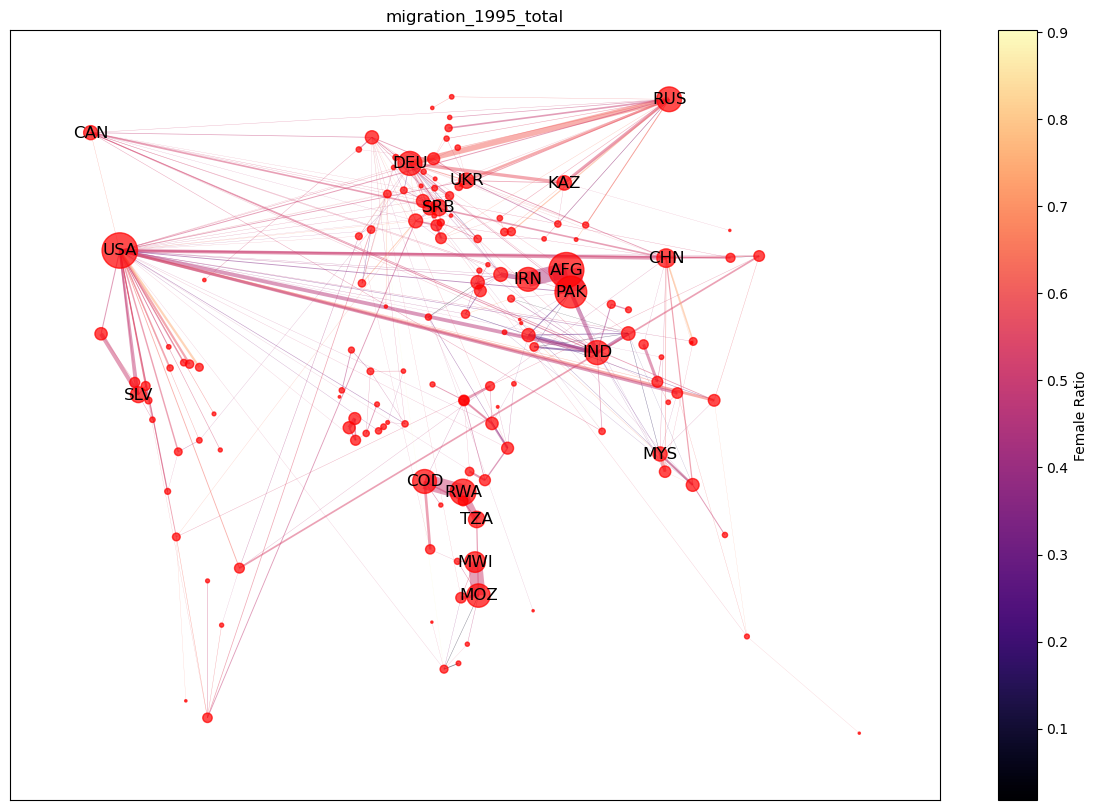

In [96]:
# visualizing the first undirected graph
visualize_graph(undirected_graphs[0], nodes_df, migration_years[0])

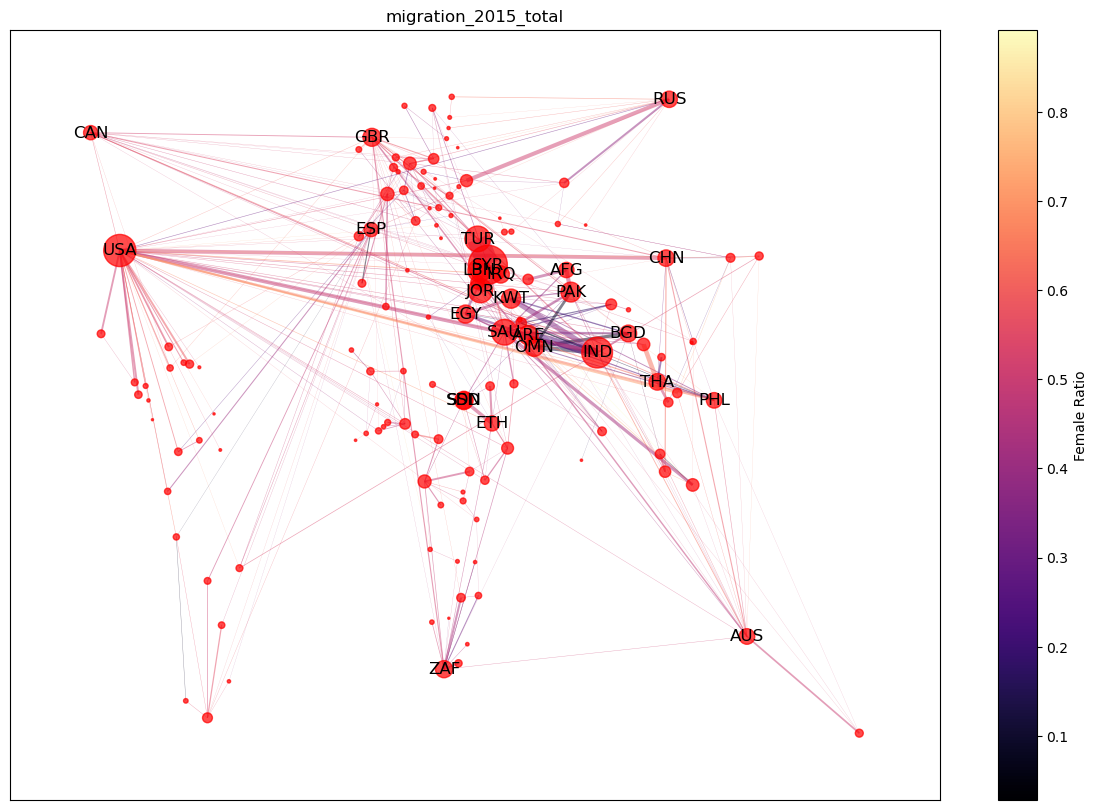

In [97]:
# visualizing the last undirected graph
visualize_graph(undirected_graphs[-1], nodes_df, migration_years[-1])

In [98]:
import community as community_louvain

# Position, size, and labels
node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in undirected_graphs[0].nodes}
node_sizes = [graphs[0].degree(n, weight='weight')/5000 for n in undirected_graphs[0].nodes()]
labels = get_high_degree_labels(undirected_graphs[0], nodes_df)

edge_weights = [d['weight'] / 100000 for _, _, d in undirected_graphs[0].edges(data=True)]

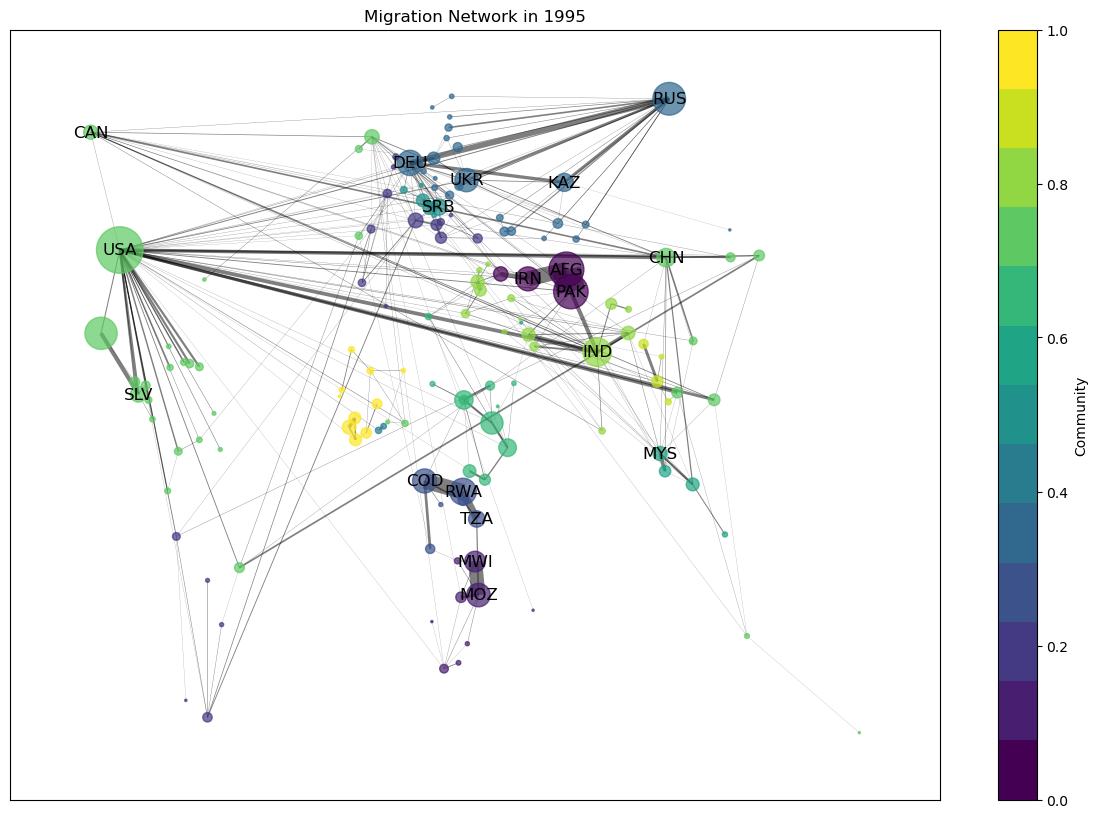

In [113]:
# Applying the Louvain method for community detection in the all undirected graph
partition = community_louvain.best_partition(undirected_graphs[0], weight='weight', resolution=1.0)

# Adding community information to the nodes for visualization
for node in undirected_graphs[0].nodes:
    undirected_graphs[0].nodes[node]['community'] = partition[node]

# Using a color map to distinguish different communities
community_colors = [partition[node] for node in undirected_graphs[0].nodes]
cmap = plt.get_cmap('viridis', max(community_colors) + 1)
node_colors = [cmap(i) for i in community_colors]

# Visualization
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(undirected_graphs[0], node_positions, node_size=node_sizes, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(undirected_graphs[0], node_positions, width=edge_weights, alpha=0.5)
nx.draw_networkx_labels(undirected_graphs[0], node_positions, labels=labels, font_size=12)
plt.title('Migration Network in 1995')
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), orientation='vertical', label='Community')
plt.show()


In [114]:
# checkin the number of communities
print(f'Number of communities: {len(set(partition.values()))}')

Number of communities: 13


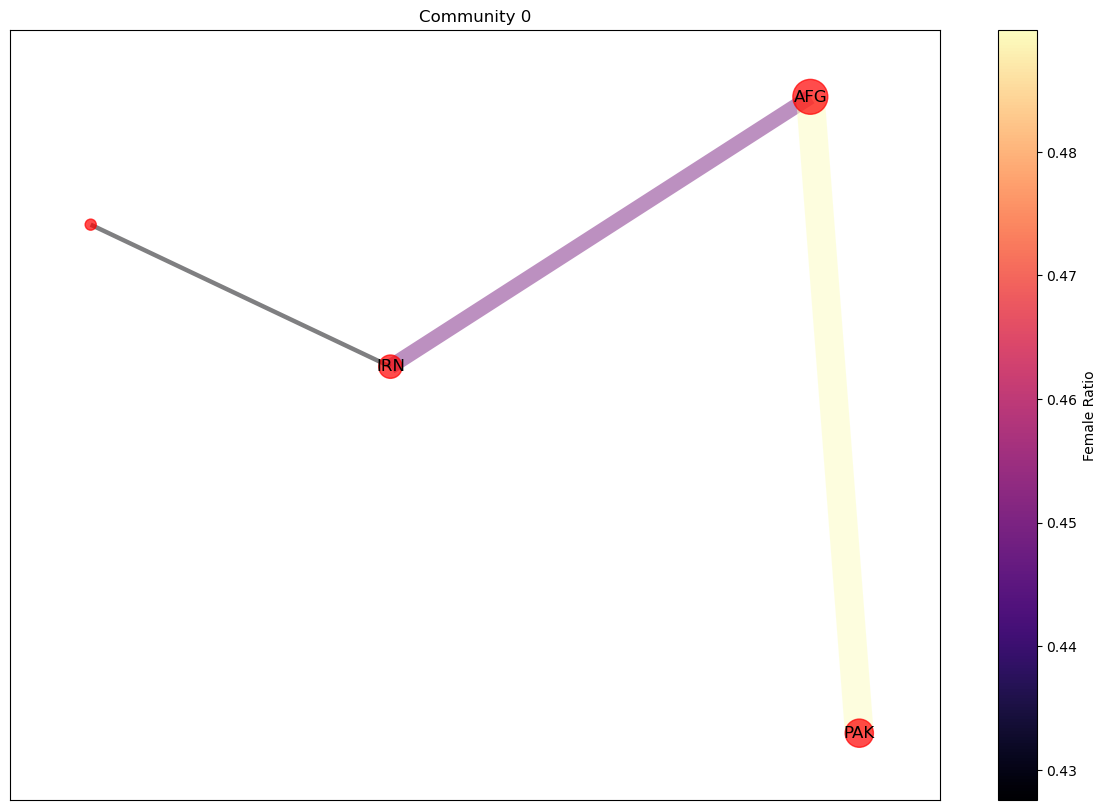

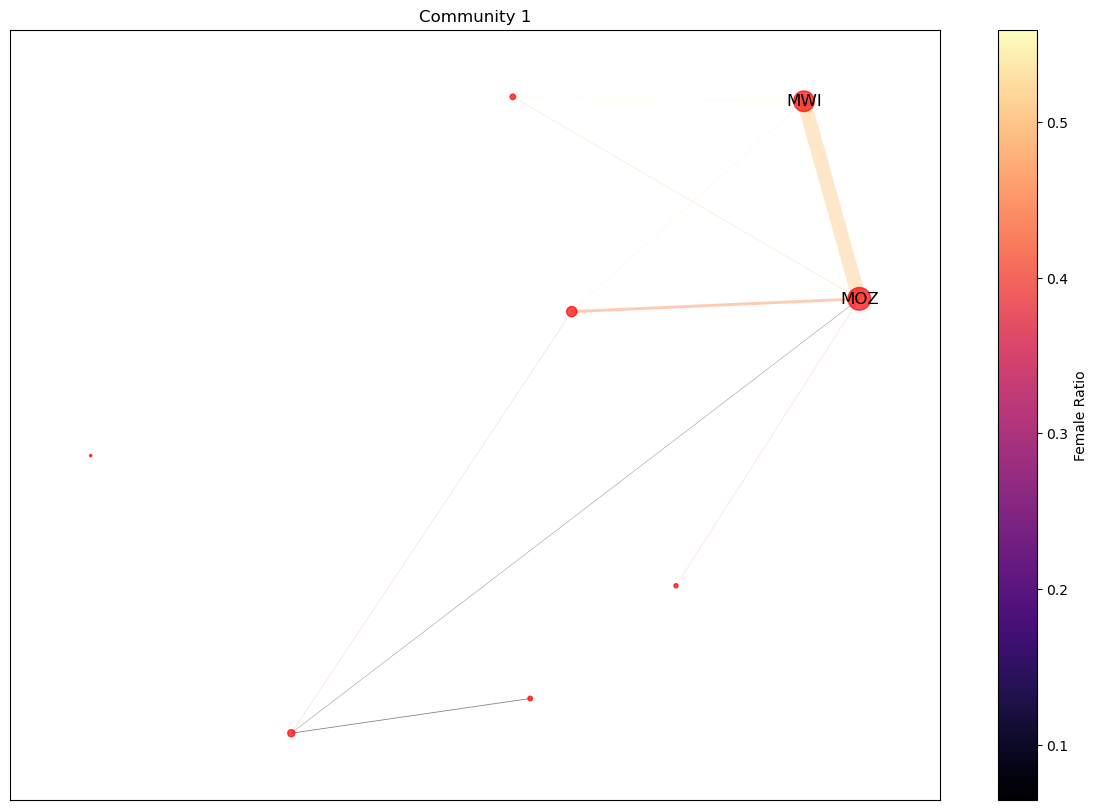

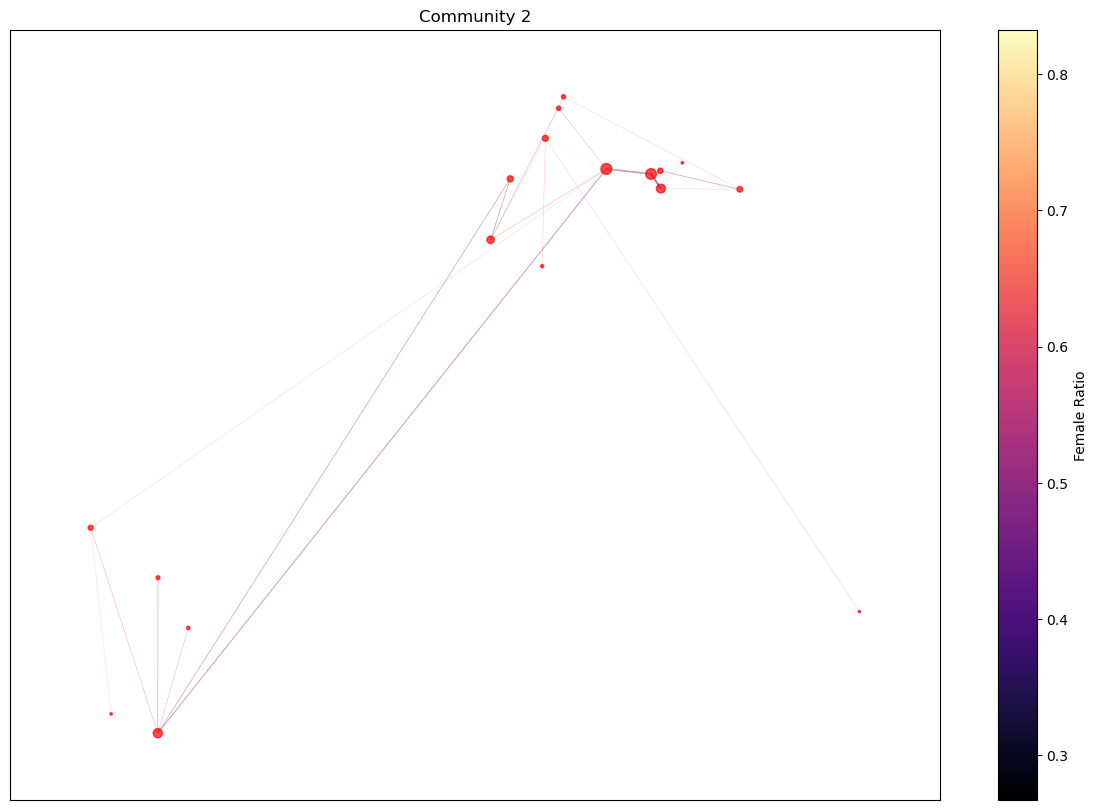

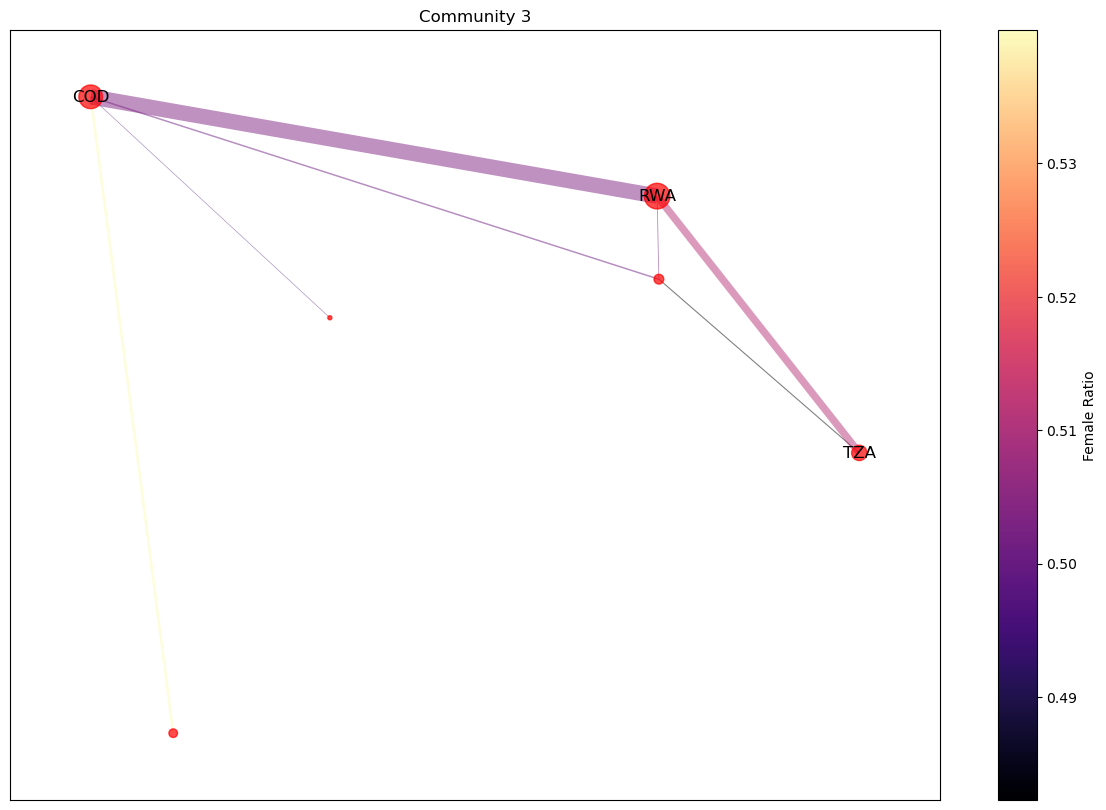

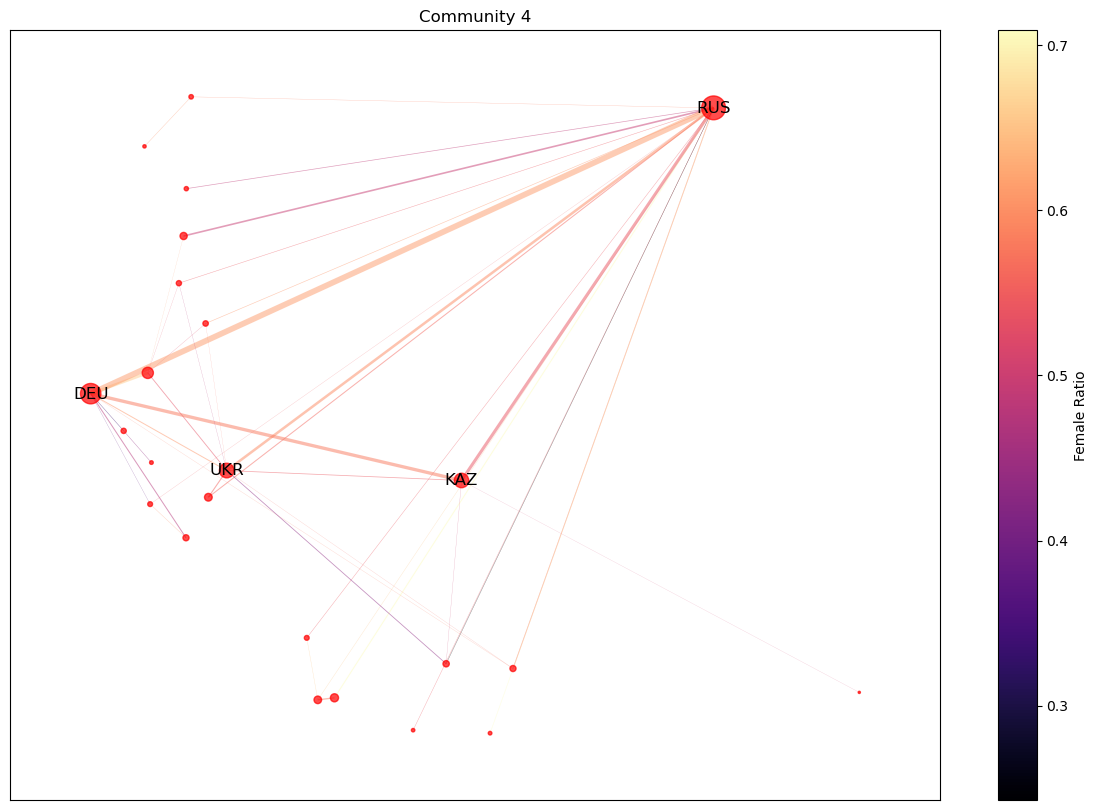

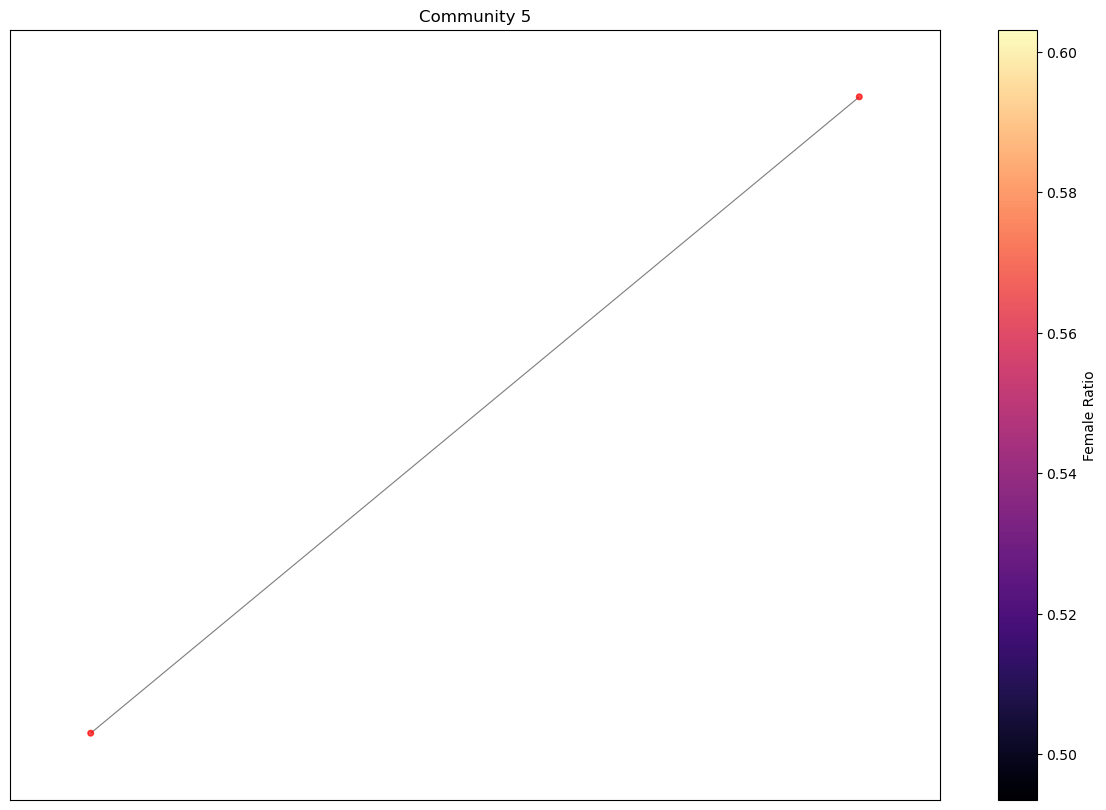

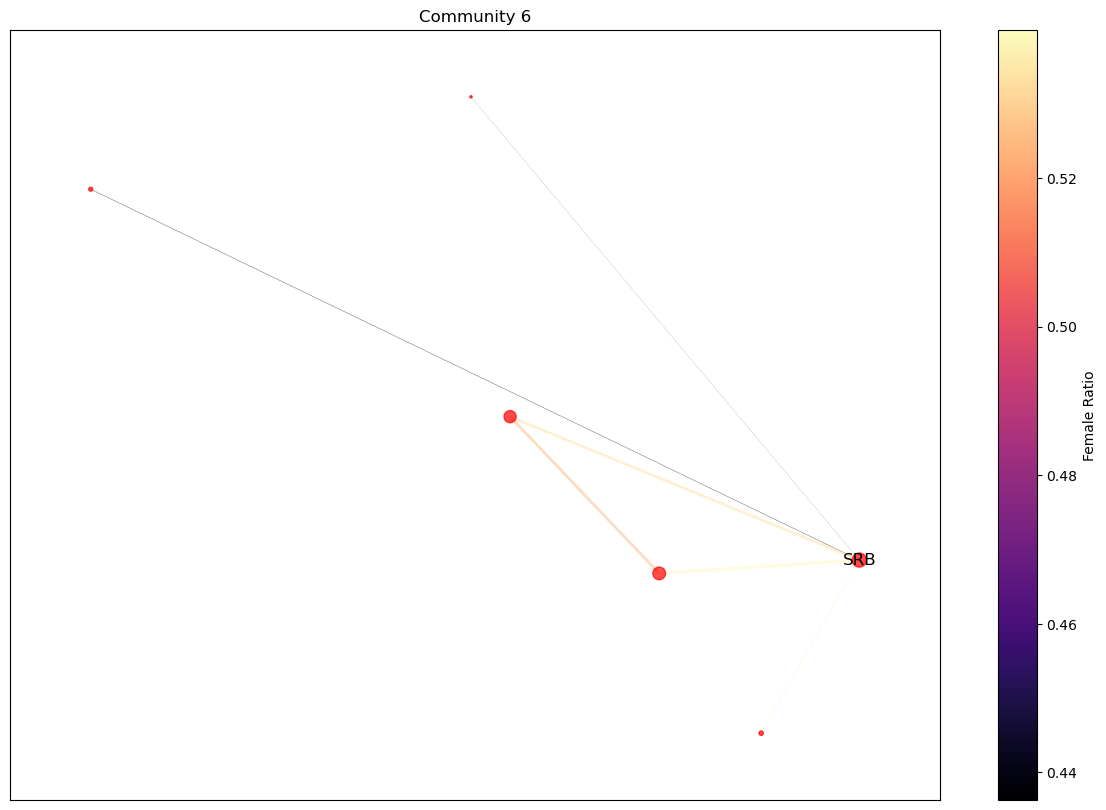

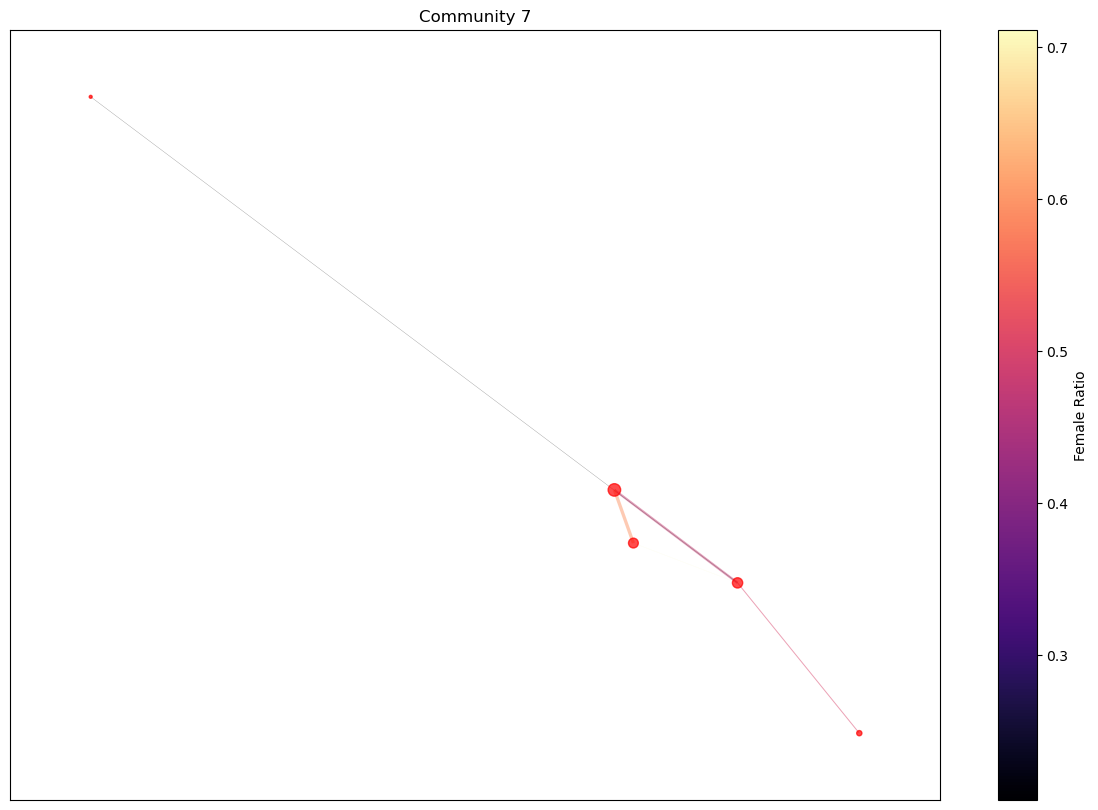

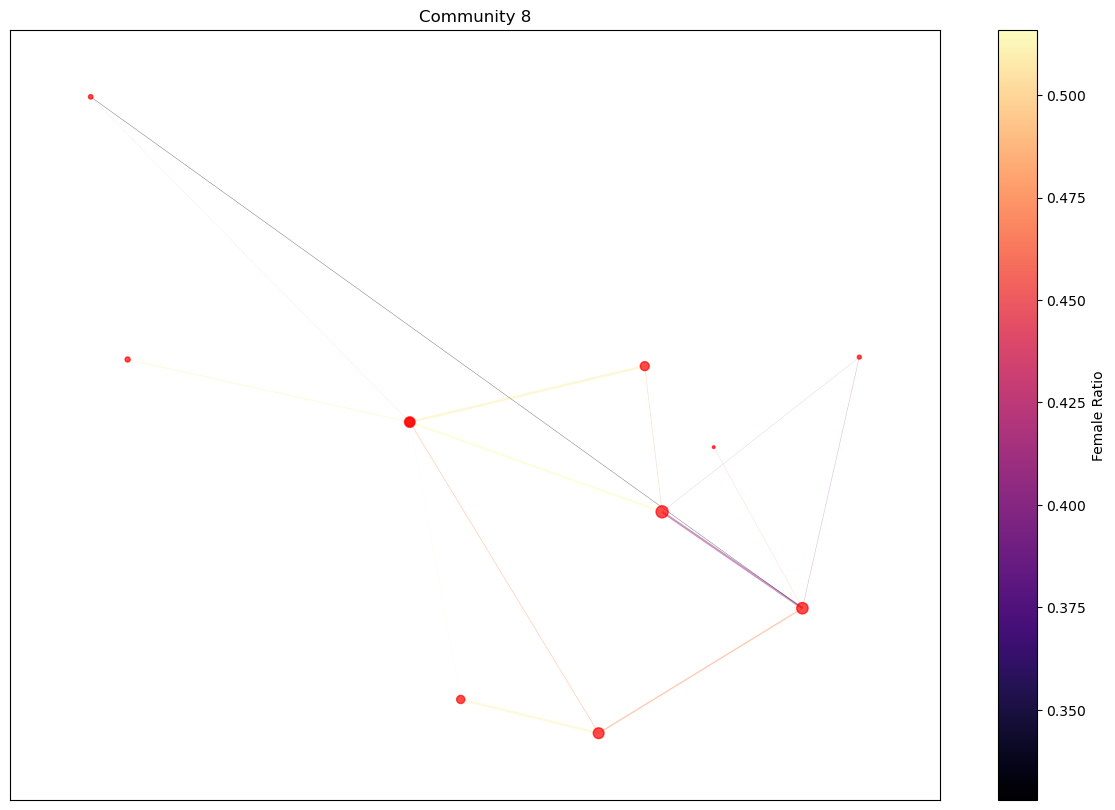

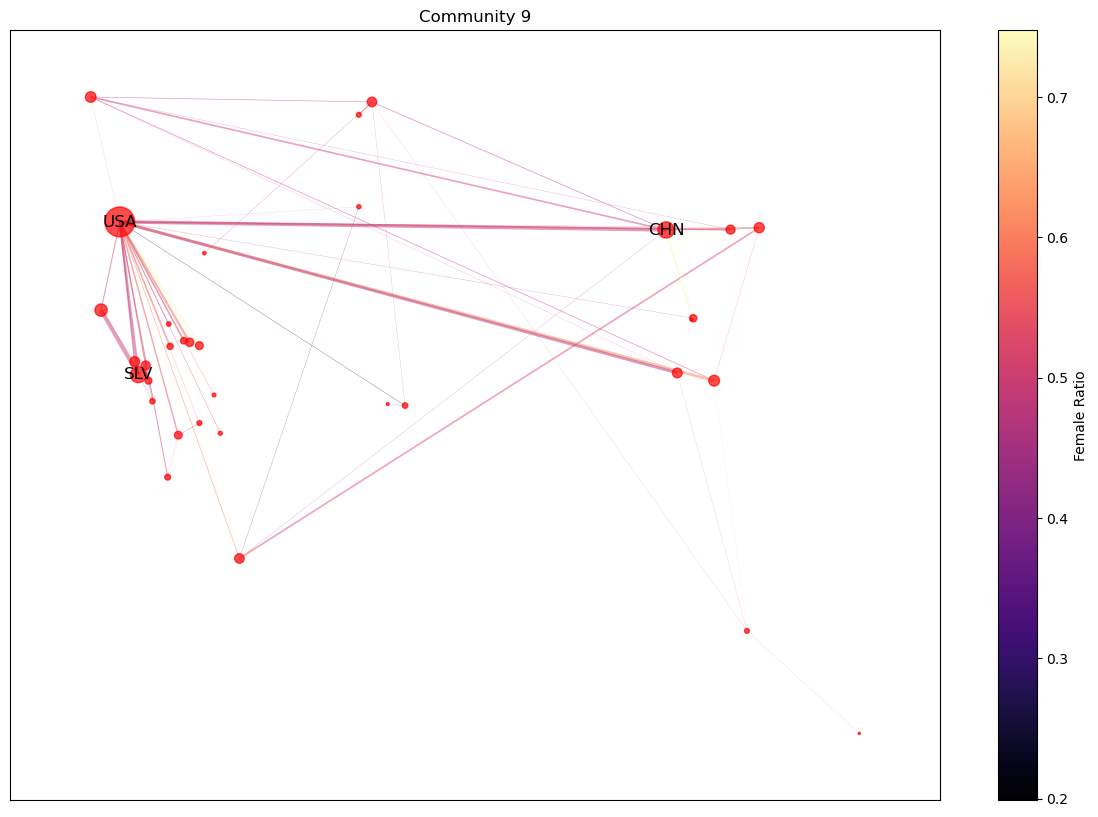

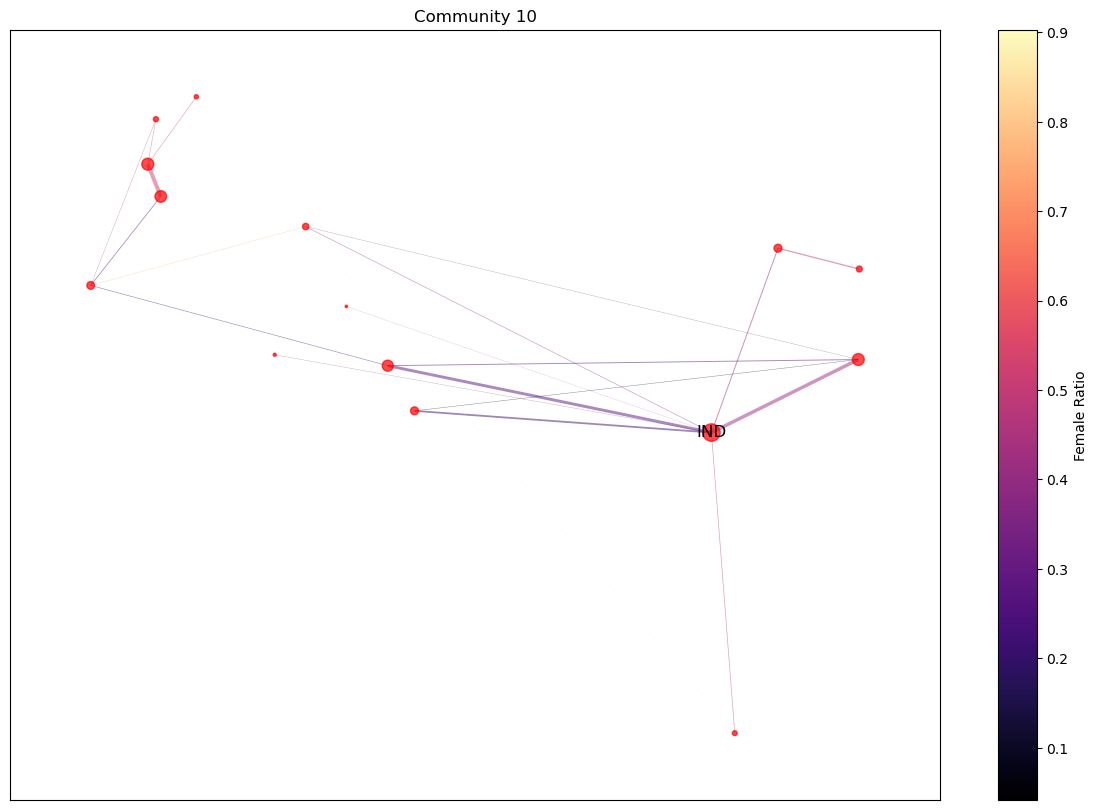

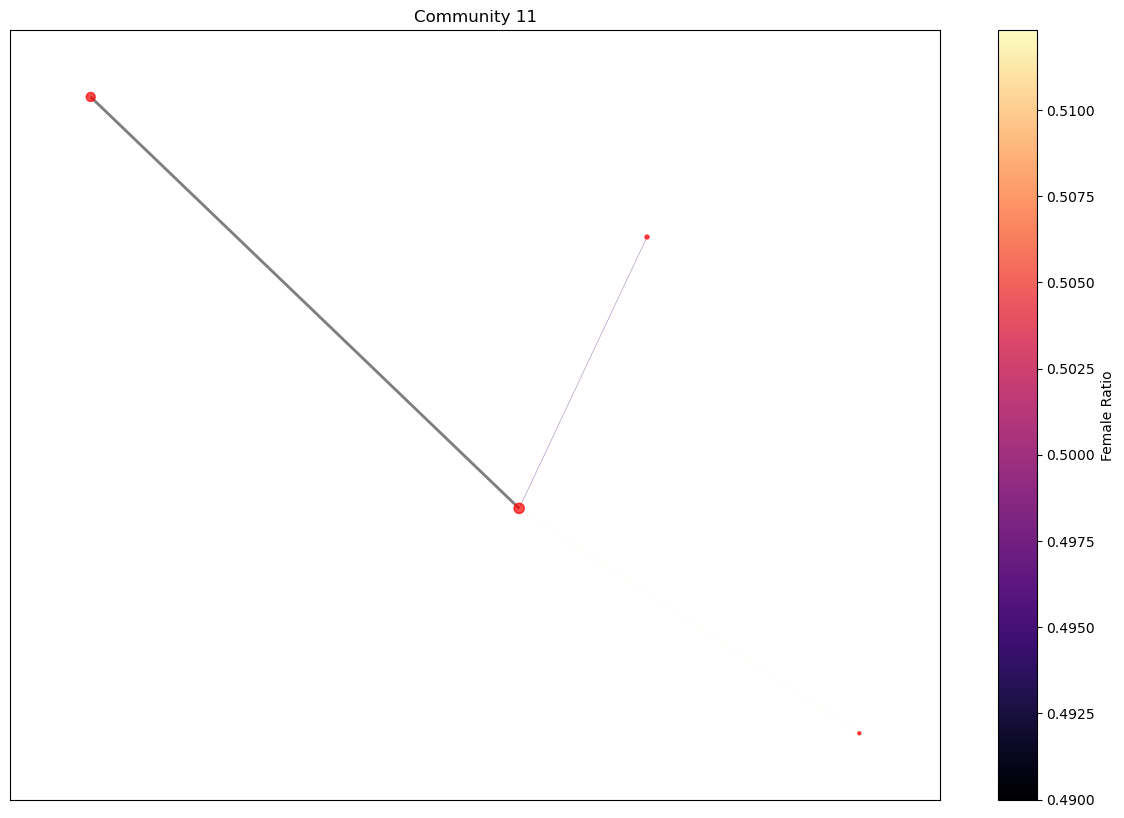

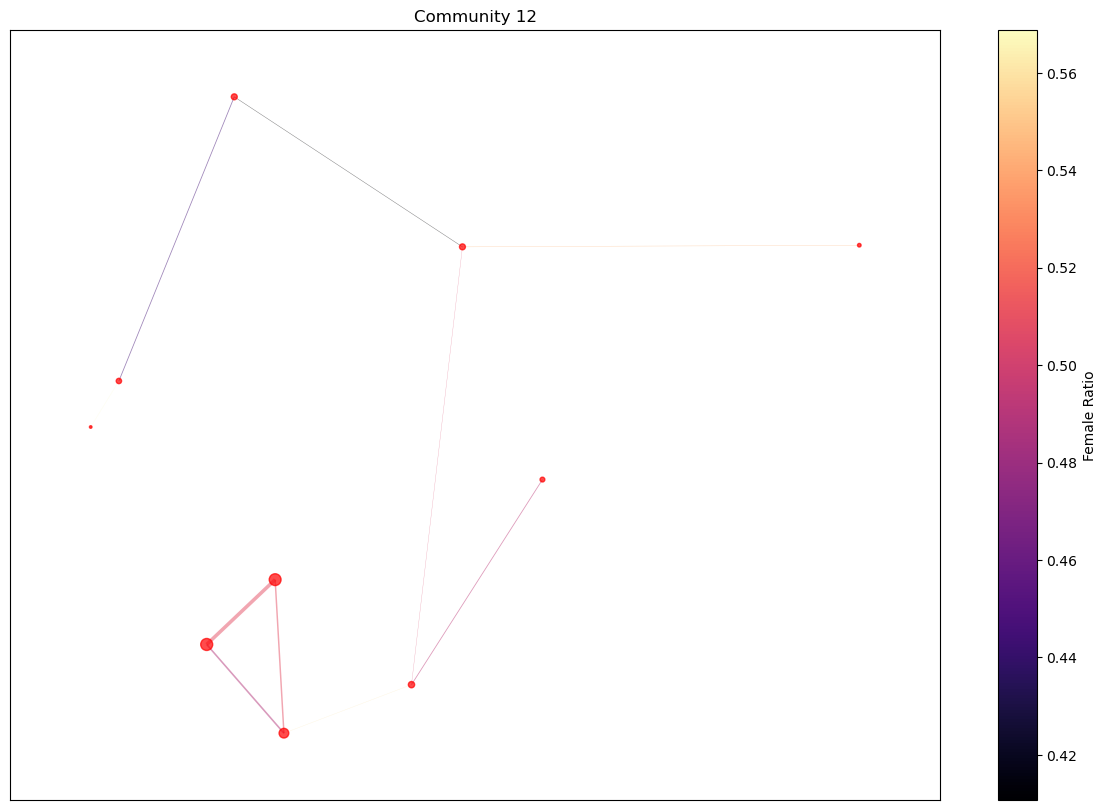

In [115]:
# Storing the subgraphs in a list
subgraphs = []
for community in set(partition.values()):
    nodes = [n for n in undirected_graphs[0].nodes() if undirected_graphs[0].nodes[n]['community'] == community]
    subgraphs.append(undirected_graphs[0].subgraph(nodes))

# Visualizing the subgraphs showing the l
for i, subgraph in enumerate(subgraphs):
    visualize_graph(subgraph, nodes_df, f'Community {i}')
    

In [43]:
# printing the name of the node (abb) with highest weighted degree in each community
for i, subgraph in enumerate(subgraphs):
    print(f'Community {i}: {get_high_degree_labels(subgraph, nodes_df)}')

Community 0: {0: 'AFG', 99: 'IRN'}
Community 1: {}
Community 2: {58: 'COD', 171: 'RWA'}
Community 3: {43: 'CHN', 97: 'IND', 124: 'MYS'}
Community 4: {80: 'DEU', 108: 'KAZ', 170: 'RUS', 216: 'UKR'}
Community 5: {65: 'SLV', 220: 'USA'}
Community 6: {}
Community 7: {123: 'MWI', 140: 'MOZ'}
Community 8: {}
Community 9: {}
Community 10: {}
Community 11: {}


In [44]:
for i, subgraph in enumerate(subgraphs):
    print(f'Community {i}: {max(subgraph.degree(weight="weight"), key=lambda x: x[1])}')

Community 0: (99, 1414802)
Community 1: (104, 291668)
Community 2: (58, 1345283)
Community 3: (97, 959821)
Community 4: (170, 1416013)
Community 5: (220, 1724632)
Community 6: (184, 378699)
Community 7: (140, 1206658)
Community 8: (69, 376777)
Community 9: (132, 9866)
Community 10: (195, 371832)
Community 11: (203, 248211)


In [45]:
# Detecting communities for each undirected graph and storing the results in a list
partitions = []
for graph in undirected_graphs:
    partitions.append(community_louvain.best_partition(graph, weight='weight'))

# Adding community information to the nodes for visualization
for i, graph in enumerate(undirected_graphs):
    for node in graph.nodes:
        graph.nodes[node]['community'] = partitions[i][node]

# Storing the subgraphs in a list
subgraphs = []
for i, graph in enumerate(undirected_graphs):
    subgraphs.append([])
    for community in set(partitions[i].values()):
        nodes = [n for n in graph.nodes() if graph.nodes[n]['community'] == community]
        subgraphs[i].append(graph.subgraph(nodes))



In [61]:
# printning the communities in the second graph
for i, subgraph in enumerate(subgraphs[4]):
    print(f'Community {i}: {get_high_degree_labels(subgraph, nodes_df)}')

Community 0: {0: 'AFG', 16: 'BGD', 64: 'EGY', 97: 'IND', 111: 'KWT', 154: 'OMN', 155: 'PAK', 180: 'SAU', 217: 'ARE'}
Community 1: {170: 'RUS'}
Community 2: {191: 'ZAF'}
Community 3: {220: 'USA'}
Community 4: {}
Community 5: {}
Community 6: {}
Community 7: {69: 'ETH', 192: 'SSD', 196: 'SDN'}
Community 8: {100: 'IRQ', 107: 'JOR', 115: 'LBN', 201: 'SYR', 211: 'TUR'}


In [66]:
# printning all the nodes from the first community in the second graph
print(f'Community 0: {subgraphs[3][0].nodes()}')


Community 0: [113, 203, 141]


In [67]:
# Seperating the nodes with highest weighted degree in each community of the first graph
high_degree_nodes = []
for i, subgraph in enumerate(subgraphs[0]):
    high_degree_nodes.append(max(subgraph.degree(weight="weight"), key=lambda x: x[1])[0])

high_degree_nodes

[99, 104, 58, 97, 170, 220, 184, 140, 203, 69, 132]

In [73]:
# In each undirected graph, finding the community of the node 99
for i, graph in enumerate(undirected_graphs):
    print(f'Community of node 99 in graph {i}: {graph.nodes[99]["community"]}')


Community of node 99 in graph 0: 0
Community of node 99 in graph 1: 0
Community of node 99 in graph 2: 0
Community of node 99 in graph 3: 2
Community of node 99 in graph 4: 0


In [74]:
# print the nodes of the third community in the fourth graph
print(f'Community 2: {subgraphs[3][2].nodes()}')

Community 2: [0, 99]


In [76]:
# In each undirected graph, finding the community of the node 104
for i, graph in enumerate(undirected_graphs):
    print(f'Community of node 104 in graph {i}: {graph.nodes[104]["community"]}')

Community of node 104 in graph 0: 1
Community of node 104 in graph 1: 1
Community of node 104 in graph 2: 1
Community of node 104 in graph 3: 1
Community of node 104 in graph 4: 1


In [77]:
# In each undirected graph, finding the community of the node 58
for i, graph in enumerate(undirected_graphs):
    print(f'Community of node 58 in graph {i}: {graph.nodes[58]["community"]}')

Community of node 58 in graph 0: 2
Community of node 58 in graph 1: 8
Community of node 58 in graph 2: 10
Community of node 58 in graph 3: 3
Community of node 58 in graph 4: 2


In [78]:
# In each undirected graph, finding the community of the node 97
for i, graph in enumerate(undirected_graphs):
    print(f'Community of node 97 in graph {i}: {graph.nodes[97]["community"]}')

Community of node 97 in graph 0: 3
Community of node 97 in graph 1: 5
Community of node 97 in graph 2: 7
Community of node 97 in graph 3: 8
Community of node 97 in graph 4: 0
